In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from tensorflow.keras.models import load_model

sb.set(context='talk', style='white', palette='Set1')
plt.rcParams["font.family"] = "serif"

sys.path.insert(0, '/home/ubuntu/Documents/NMDinStars/mcmc/SMwithIMF')
from ML_Helpers import inverseMinNormalize, minNormalize, norm1

In [3]:
# read in ML algorithms

classifier = load_model('/home/ubuntu/Documents/NMDinStars/ML_models/classifier/classify_mesa.h5')
regressor = load_model('/home/ubuntu/Documents/NMDinStars/ML_models/regressor/IBand.h5')  

# read in Iband and Ierr error files
IbandErr = np.load('/home/ubuntu/Documents/NMDinStars/ML_models/SM/Iband_error.npy')
IerrErr = np.load('/home/ubuntu/Documents/NMDinStars/ML_models/SM/Ierr_error.npy')

In [4]:
def ML(theta):
    '''
    Use the ML classiifer and regressor to predict the I-Band
    magnitudes given mass, Y, Z, mu_12
    '''
    # read in normalization constants
    #constReg = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/regressor/regression_norm_const.txt', index_col=0)
    #constClass = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/classifier/classify_norm_const.txt', index_col=0)
    const = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/norm_const.txt', index_col=0)
    # normalize the input vector
    m, y, z, mu = theta
    
    m = norm1(m, const['min'].loc['mass'], const['max'].loc['mass'])
    y = norm1(y, const['min'].loc['y'], const['max'].loc['y'])
    z = norm1(z, const['min'].loc['z'], const['max'].loc['z'])
    mu = norm1(mu, const['min'].loc['mu'], const['max'].loc['mu'])
    thetaNorm = np.array([m, y, z, mu])[None,:]
    #print(thetaNorm)
    # call the ML models
    flag = classifier(thetaNorm).numpy()
    
    flag = np.argmax(flag)
    
    if flag != 0:
        return -np.inf, -np.inf, flag
    
    IbandNorm, IerrNorm = regressor(thetaNorm).numpy()[0]
    
    # denormalize Iband and Ierr
    Iband = inverseMinNormalize(IbandNorm,
                                const['min'].loc['M_I'],
                                const['max'].loc['M_I'])
    Ierr = inverseMinNormalize(IerrNorm,
                               const['min'].loc['M_I_err'],
                               const['max'].loc['M_I_err'])
    
    return Iband, Ierr, flag

In [8]:
# Initiate sample grid

N = 100

Y = 0.25 # give constant Y because it has no effect on I-band magnitude
mus = [0, 1, 4] # some test values of mu to vary over

Zs = np.linspace(1e-4, 0.04, N)
Ms = np.linspace(0.7, 2.25, N)

outDict = {'M':[], 'Y':[], 'Z':[], 'mu':[], 'Iband':[], 'Ierr':[]}

for mu in mus:
    for Z in Zs:
        for M in Ms:
            
            theta = [M, Y, Z, mu]
            Iband, Ierr, flag = ML(theta)
            outDict['M'].append(M)
            outDict['Y'].append(Y)
            outDict['Z'].append(Z)
            outDict['mu'].append(mu)
            outDict['Iband'].append(Iband)
            outDict['Ierr'].append(Ierr)

In [12]:
out = pd.DataFrame(outDict)
out = out[np.isfinite(out.Iband)]

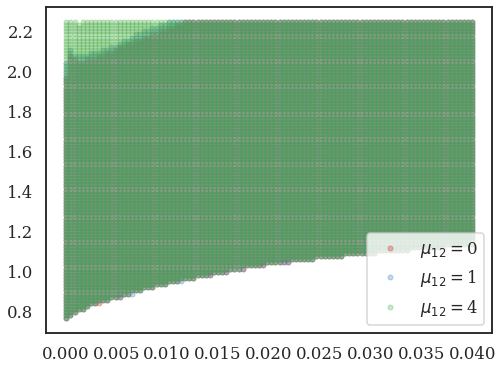

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ms = 5
for mu in out.mu.unique():
    toPlot = out[out.mu == mu]
    ax.plot(toPlot.Z, toPlot.M, 'o', alpha=0.3, markersize=ms, label=r'$\mu_{12}=$' + str(round(mu, 1)))

ax.legend()